In [ ]:
!nvidia-smi

Sat Aug 29 01:55:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 15
verbose = 2

In [ ]:
def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    train_ratio = 0.9
    train = pd.read_csv(path)
    point_to = int(len(train) * train_ratio)
    train_data = train.iloc[:point_to]
    test_data = train.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data.iloc[:, 3:].applymap(lambda x: x / 255.).values.reshape(-1, 28, 28, 1)
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data.iloc[:, 3:].applymap(lambda x: x / 255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    cnn_input = layers.Input(shape=(28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs=cnn_input, outputs=cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation='relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid), callbacks=[annealer],
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Epoch 1/15
510/510 - 3s - loss: 1.8869 - accuracy: 0.3080 - val_loss: 1.2139 - val_accuracy: 0.5825
Epoch 2/15
510/510 - 3s - loss: 1.0582 - accuracy: 0.6358 - val_loss: 0.8364 - val_accuracy: 0.7143
Epoch 3/15
510/510 - 3s - loss: 0.7518 - accuracy: 0.7390 - val_loss: 0.6003 - val_accuracy: 0.7933
Epoch 4/15
510/510 - 3s - loss: 0.6033 - accuracy: 0.7940 - val_loss: 0.5187 - val_accuracy: 0.8213
Epoch 5/15
510/510 - 3s - loss: 0.5032 - accuracy: 0.8230 - val_loss: 0.4960 - val_accuracy: 0.8279
Epoch 6/15
510/510 - 3s - loss: 0.4219 - accuracy: 0.8525 - val_loss: 0.3911 - val_accuracy: 0.8655
Epoch 7/15
510/510 - 3s - loss: 0.3664 - accuracy: 0.8688 - val_loss: 0.3793 - val_accuracy: 0.8702
Epoch 8/15
510/510 - 3s - loss: 0.3167 - accuracy: 0.8895 - val_loss: 0.3123 - val_accuracy: 0.8989
Epoch 9/15
510/510 - 3s - loss: 0.2767 - accuracy: 0.8996 - val_loss: 0.2893 - val_accuracy: 0.9011
Epoch 10/15
510/510 - 3s - loss: 0.2529 - accuracy: 0.9104 - val_loss: 0.2832 - val_accuracy: 0.9070

Model 2
===========

upscaling 이 오래 걸리니 시행해서 저장하자.
------------
(2배 : 56*56)
------------

In [ ]:
import pandas as pd
import numpy as np
import math
import sys

# Interpolation kernel
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

#Paddnig
def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

# https://github.com/yunabe/codelab/blob/master/misc/terminal_progressbar/progress.py
def get_progressbar_str(progress):
    END = 170
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

# Bicubic operation
def bicubic(img, ratio = 2, a = -0.5):
    #Get image size
    H,W,C = img.shape

    img = padding(img,H,W,C)
    #Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
    dst = np.zeros((dH, dW, 1))

    h = 1/ratio

    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2 , j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)
    return dst

def Upscale_and_Save():
    train = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')
    pixel = train.iloc[:,3:].values.reshape(-1,28,28,1)
    L = len(pixel)
    result = np.zeros((L,56,56,1))
    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
    for row in range(L):
        result[row] = bicubic(pixel[row])

        # Print progress
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
        
    sys.stderr.write('\n')
    sys.stderr.flush()

    result = pd.DataFrame(result.reshape(-1,56*56))
    result.to_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic56.csv')
    print('Complete !!')

Upscale_and_Save()

Progress:[>                              ] 0.0%

Start bicubic interpolation
It will take a little while...


Progress:[==============================] 100.0%


Complete !!


(4배 : 112*112)
------------

In [ ]:
import pandas as pd
import numpy as np
import math
import sys

# Interpolation kernel
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

#Paddnig
def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

# https://github.com/yunabe/codelab/blob/master/misc/terminal_progressbar/progress.py
def get_progressbar_str(progress):
    END = 170
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

# Bicubic operation
def bicubic(img, ratio = 4, a = -0.5):
    #Get image size
    H,W,C = img.shape

    img = padding(img,H,W,C)
    #Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
    dst = np.zeros((dH, dW, 1))

    h = 1/ratio

    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2 , j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)
    return dst

def Upscale_and_Save():
    train = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')
    pixel = train.iloc[:,3:].values.reshape(-1,28,28,1)
    L = len(pixel)
    result = np.zeros((L,112,112,1))
    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
    for row in range(L):
        result[row] = bicubic(pixel[row])

        # Print progress
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
        
    sys.stderr.write('\n')
    sys.stderr.flush()

    result = pd.DataFrame(result.reshape(-1,112*112))
    result.to_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv')
    print('Complete !!')

Upscale_and_Save()

Start bicubic interpolation
It will take a little while...


Progress:[==============================] 100.0%


Complete !!


(8배 : 224 * 224)
-------------

In [ ]:
import pandas as pd
import numpy as np
import math
import sys

# Interpolation kernel
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

#Paddnig
def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

# https://github.com/yunabe/codelab/blob/master/misc/terminal_progressbar/progress.py
def get_progressbar_str(progress):
    END = 170
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

# Bicubic operation
def bicubic(img, ratio = 8, a = -0.5):
    #Get image size
    H,W,C = img.shape

    img = padding(img,H,W,C)
    #Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
    dst = np.zeros((dH, dW, 1))

    h = 1/ratio

    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2 , j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)
    return dst

def Upscale_and_Save():
    train = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')
    pixel = train.iloc[:,3:].values.reshape(-1,28,28,1)
    L = len(pixel)
    result = np.zeros((L,224,224,1))
    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
    for row in range(L):
        result[row] = bicubic(pixel[row])

        # Print progress
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
        
    sys.stderr.write('\n')
    sys.stderr.flush()

    result = pd.DataFrame(result.reshape(-1,224*224))
    result.to_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic224.csv')
    print('Complete !!')

Upscale_and_Save()

Start bicubic interpolation
It will take a little while...


Progress:[==============================] 100.0%


Complete !!


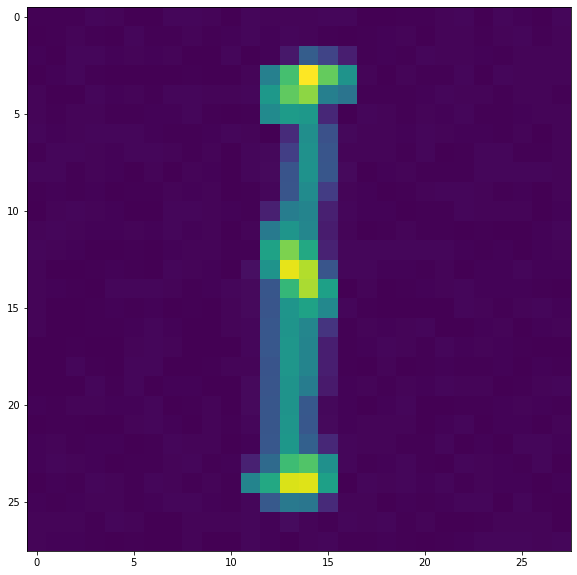

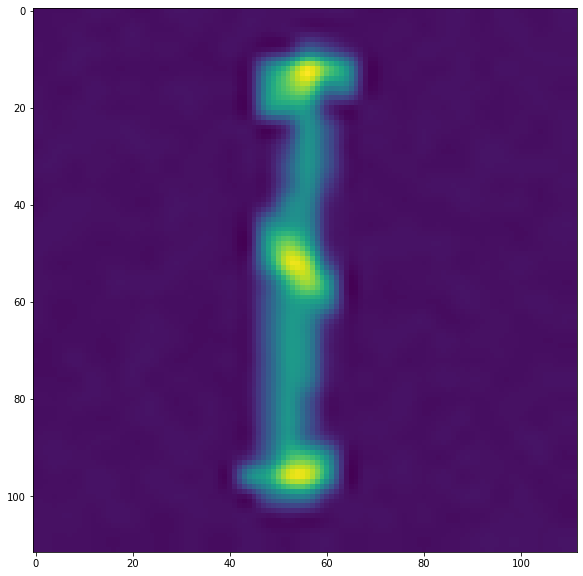

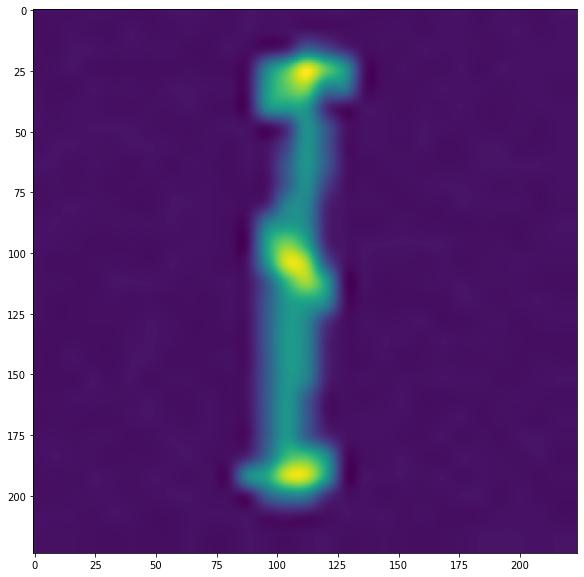

In [ ]:
def image_view(pdSeries):
    pixels = np.array(pdSeries.iloc[3:].map(lambda x : float(x))).reshape((28,28))
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
def image_view2(pdSeries):
    pixels = np.array(pdSeries.iloc[1:].map(lambda x : float(x))).reshape((112,112))
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
def image_view3(pdSeries):
    pixels = np.array(pdSeries.iloc[1:].map(lambda x : float(x))).reshape((224,224))
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
ser1 = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv').iloc[0]
ser2 = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv').iloc[0]
ser3 = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic224.csv').iloc[0]
image_view(ser1)
image_view2(ser2)
image_view3(ser3)

testset 8 배
--------

In [ ]:
import pandas as pd
import numpy as np
import math
import sys

# Interpolation kernel
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

#Paddnig
def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

# https://github.com/yunabe/codelab/blob/master/misc/terminal_progressbar/progress.py
def get_progressbar_str(progress):
    END = 170
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

# Bicubic operation
def bicubic(img, ratio = 8, a = -0.5):
    #Get image size
    H,W,C = img.shape

    img = padding(img,H,W,C)
    #Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
    dst = np.zeros((dH, dW, 1))

    h = 1/ratio

    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2 , j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)
    return dst

def normalization(pixel_data):
    pixel_data = pixel_data.reshape(224 * 224)
    maxi = max(pixel_data)
    mini = min(pixel_data)
    if maxi == mini:
        pixel_data = np.array(list(map(lambda x : 0, pixel_data)))
    else:
        pixel_data = np.array(list(map(lambda x : (x - mini)/(maxi - mini), pixel_data)))
    return pixel_data


pixel = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/test.csv').iloc[:,2:].values.reshape(-1,28,28,1)
L = len(pixel)
try:
    result = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/test_bicubic224.csv').iloc[:,1:].values
    from_idx = 0
    print('preparing for the check point...')
    standard = result[-1]
    while (result[from_idx] != standard).all():
        from_idx += 1
    print('Start bicubic interpolation')
    print('It will take a little while...')
    print('from index',from_idx)
    inc = int(from_idx)
    for row in range(from_idx,L):
        result[row] = normalization(bicubic(pixel[row]))
        # Print progress
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
except KeyboardInterrupt:
    print('this ended earlier in idx',row)
'''except:
    result = np.zeros((L,224 * 224))
    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
    for row in range(L):
        result[row] = normalization(bicubic(pixel[row]))
        # Print progress
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
finally:
    sys.stderr.write('\n')
    sys.stderr.flush()

    result = pd.DataFrame(result)
    result.to_csv('/content/gdrive/My Drive/Dacon/ComputerVision/test_bicubic224.csv')
    print('Complete !!')'''


preparing for the check point...
Start bicubic interpolation
It will take a little while...
from index 76


Progress:[>                              ] 0.4%

IndexError: ignored

In [ ]:
sys.stderr.write('\n')
sys.stderr.flush()

result = pd.DataFrame(result)
result.to_csv('/content/gdrive/My Drive/Dacon/ComputerVision/test_bicubic224.csv')
print('Complete !!')

In [ ]:
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50136,50137,50138,50139,50140,50141,50142,50143,50144,50145,50146,50147,50148,50149,50150,50151,50152,50153,50154,50155,50156,50157,50158,50159,50160,50161,50162,50163,50164,50165,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,0.061590,0.062887,0.064825,0.067153,0.069621,0.071977,0.073971,0.075351,0.075867,0.075302,0.073804,0.071663,0.069175,0.066630,0.064323,0.062545,0.061590,0.061457,0.061869,0.062698,0.063821,0.065110,0.066442,0.067690,0.068729,0.069718,0.070848,0.072033,0.073190,0.074236,0.075086,0.075658,0.075867,0.075585,0.074835,0.073765,0.072521,0.071249,0.070095,0.069206,...,0.075940,0.075957,0.075626,0.075053,0.074345,0.073609,0.072952,0.072479,0.072298,0.072503,0.073035,0.073765,0.074567,0.075312,0.075875,0.076127,0.075940,0.075134,0.073750,0.072000,0.070094,0.068244,0.066660,0.065554,0.065135,0.065519,0.066555,0.068054,0.069826,0.071682,0.073434,0.074892,0.075867,0.076381,0.076622,0.076653,0.076538,0.076339,0.076119,0.075940
1,0.074671,0.073705,0.072261,0.070527,0.068688,0.066933,0.065448,0.064420,0.064035,0.064516,0.065780,0.067556,0.069575,0.071566,0.073259,0.074384,0.074671,0.073965,0.072455,0.070392,0.068024,0.065600,0.063370,0.061584,0.060490,0.060109,0.060213,0.060677,0.061376,0.062186,0.062983,0.063641,0.064035,0.064229,0.064368,0.064451,0.064478,0.064451,0.064368,0.064229,...,0.074744,0.074483,0.073790,0.072791,0.071610,0.070373,0.069206,0.068233,0.067581,0.067258,0.067149,0.067193,0.067327,0.067490,0.067620,0.067655,0.067532,0.067212,0.066735,0.066163,0.065558,0.064981,0.064493,0.064158,0.064035,0.064168,0.064514,0.065013,0.065601,0.066217,0.066798,0.067281,0.067605,0.067776,0.067856,0.067866,0.067828,0.067762,0.067688,0.067629
2,0.041018,0.042356,0.044356,0.046758,0.049305,0.051736,0.053794,0.055218,0.055750,0.055193,0.053707,0.051574,0.049075,0.046489,0.044097,0.042180,0.041018,0.040572,0.040558,0.040889,0.041478,0.042241,0.043090,0.043939,0.044701,0.045521,0.046543,0.047679,0.048845,0.049952,0.050916,0.051650,0.052067,0.052085,0.051751,0.051172,0.050456,0.049711,0.049046,0.048568,...,0.048384,0.048595,0.049136,0.049879,0.050694,0.051450,0.052017,0.052266,0.052067,0.051281,0.049973,0.048316,0.046486,0.044657,0.043002,0.041698,0.040917,0.040626,0.040642,0.040921,0.041419,0.042090,0.042891,0.043776,0.044701,0.045814,0.047222,0.048815,0.050487,0.052130,0.053635,0.054894,0.055801,0.056332,0.056581,0.056614,0.056494,0.056288,0.056061,0.055877
3,0.085690,0.085346,0.084810,0.084163,0.083490,0.082871,0.082390,0.082128,0.082170,0.082592,0.083352,0.084346,0.085470,0.086621,0.087697,0.088595,0.089210,0.089547,0.089705,0.089726,0.089650,0.089519,0.089375,0.089258,0.089210,0.089186,0.089127,0.089055,0.088990,0.088952,0.088962,0.089042,0.089210,0.089530,0.090007,0.090582,0.091190,0.091771,0.092263,0.092603,...,0.082121,0.081216,0.080318,0.079489,0.078793,0.078290,0.078045,0.078120,0.078577,0.079604,0.081222,0.083244,0.085480,0.087745,0.089849,0.091605,0.092826,0.093508,0.093829,0.093871,0.093718,0.093454,0.093162,0.092925,0.092826,0.092824,0.092822,0.092818,0.092814,0.092811,0.092807,0.092804,0.092802,0.092801,0.092801,0.092801,0.092801,0.092801,0.092802,0.092802
4,0.052639,0.052310,0.051818,0.051227,0.050600,0.050002,0.049496,0.049146,0.049015,0.049146,0.049496,0.050002,0.050600,0.051227,0.051818,0.052310,0.052639,0.052787,0.052809,0.052745,0.052639,0.052533,0.052469,0.052490,0.052639,0.052943,0.053375,0.053892,0.054451,0.055010,0.055527,0.055958,0.056263,0.056461,0.056603,0.056688,0.056716,0.056688,0.056603,0.056461,...,0.056213,0.056227,0.055893,0.055317,0.054608,0.053871,0.053213,0.052742,0.052564,0.052678,0.052979,0.053425,0.053971,0.054575,0.055191,0.055777,0.056288,0.056745,0.057201,0.057654,0.058106,0.058557,0.059008,0.059459,0.059912,0.060390,0.060903,0.061430,0.061950,0.062442,0.062885,0.063256,0.063536,0.063709,0.063791,0.063801,0.063762,0.063695,0.063621,0.063561
...,...,...,...

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


resnet50 + bicubic56

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic56.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 56, 56, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 56, 56, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(56,56,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Boundary Clear
Boundary Clear
Epoch 1/20
510/510 [==============================] - 30s 58ms/step - loss: 1.9742 - accuracy: 0.2768 - val_loss: 9.6535 - val_accuracy: 0.0992
Epoch 2/20
510/510 [==============================] - 29s 56ms/step - loss: 1.1165 - accuracy: 0.6250 - val_loss: 1.5976 - val_accuracy: 0.5557
Epoch 3/20
510/510 [==============================] - 28s 55ms/step - loss: 0.7028 - accuracy: 0.7746 - val_loss: 1.0311 - val_accuracy: 0.7170
Epoch 4/20
510/510 [==============================] - 28s 56ms/step - loss: 0.5008 - accuracy: 0.8472 - val_loss: 0.6756 - val_accuracy: 0.7808
Epoch 5/20
510/510 [==============================] - 28s 56ms/step - loss: 0.3900 - accuracy: 0.8779 - val_loss: 0.9517 - val_accuracy: 0.7312
Epoch 6/20
510/510 [==============================] - 28s 56ms/step - loss: 0.2777 - accuracy: 0.9125 - val_loss: 0.3853 - val_accuracy: 0.8824
Epoch 7/20
510/510 [==============================] - 28s 56ms/step - loss: 0.2391 - accuracy: 0.9236 - va

resnet101v2 + bicubic56

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic56.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 56, 56, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 56, 56, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.ResNet101V2(include_top=False, weights=None, input_tensor=None, input_shape=(56,56,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

#X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Epoch 1/20
510/510 [==============================] - 48s 95ms/step - loss: 1.5410 - accuracy: 0.4612 - val_loss: 2.5664 - val_accuracy: 0.3859
Epoch 2/20
510/510 [==============================] - 46s 90ms/step - loss: 0.7339 - accuracy: 0.7575 - val_loss: 1.5159 - val_accuracy: 0.5965
Epoch 3/20
510/510 [==============================] - 46s 91ms/step - loss: 0.4756 - accuracy: 0.8420 - val_loss: 0.5387 - val_accuracy: 0.8397
Epoch 4/20
510/510 [==============================] - 46s 91ms/step - loss: 0.3531 - accuracy: 0.8830 - val_loss: 0.4840 - val_accuracy: 0.8540
Epoch 5/20
510/510 [==============================] - 46s 91ms/step - loss: 0.2654 - accuracy: 0.9112 - val_loss: 0.3896 - val_accuracy: 0.8753
Epoch 6/20
510/510 [==============================] - 46s 91ms/step - loss: 0.2216 - accuracy: 0.9270 - val_loss: 0.5149 - val_accuracy: 0.8481
Epoch 7/20
510/510 [==============================] - 46s 91ms/step - loss: 0.1839 - accuracy: 0.9400 - val_loss: 0.3190 - val_accuracy:

bicubic112 사용
---------
resnet50 + bicubic112

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 112, 112, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 112, 112, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(112,112,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Boundary Clear
Boundary Clear
Epoch 1/20
510/510 [==============================] - 59s 115ms/step - loss: 1.3859 - accuracy: 0.5299 - val_loss: 3.2509 - val_accuracy: 0.2661
Epoch 2/20
510/510 [==============================] - 57s 111ms/step - loss: 0.5902 - accuracy: 0.8095 - val_loss: 0.6411 - val_accuracy: 0.8024
Epoch 3/20
510/510 [==============================] - 57s 112ms/step - loss: 0.3732 - accuracy: 0.8773 - val_loss: 1.0811 - val_accuracy: 0.7047
Epoch 4/20
510/510 [==============================] - 57s 112ms/step - loss: 0.3101 - accuracy: 0.8998 - val_loss: 0.5176 - val_accuracy: 0.8385
Epoch 5/20
510/510 [==============================] - 57s 112ms/step - loss: 0.2158 - accuracy: 0.9269 - val_loss: 0.5162 - val_accuracy: 0.8456
Epoch 6/20
510/510 [==============================] - 57s 112ms/step - loss: 0.1835 - accuracy: 0.9394 - val_loss: 0.4168 - val_accuracy: 0.8689
Epoch 7/20
510/510 [==============================] - 57s 112ms/step - loss: 0.1635 - accuracy: 0.94

resnet101v2 + bicubic112

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 112, 112, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 112, 112, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.ResNet101V2(include_top=False, weights=None, input_tensor=None, input_shape=(112,112,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

#X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Epoch 1/20
510/510 [==============================] - 93s 182ms/step - loss: 1.1384 - accuracy: 0.6136 - val_loss: 2.7294 - val_accuracy: 0.3738
Epoch 2/20
510/510 [==============================] - 91s 178ms/step - loss: 0.4854 - accuracy: 0.8376 - val_loss: 3.4486 - val_accuracy: 0.4462
Epoch 3/20
510/510 [==============================] - 91s 178ms/step - loss: 0.3214 - accuracy: 0.8926 - val_loss: 0.3726 - val_accuracy: 0.8763
Epoch 4/20
510/510 [==============================] - 91s 178ms/step - loss: 0.2477 - accuracy: 0.9154 - val_loss: 0.3509 - val_accuracy: 0.8785
Epoch 5/20
510/510 [==============================] - 91s 178ms/step - loss: 0.1893 - accuracy: 0.9362 - val_loss: 0.8376 - val_accuracy: 0.8066
Epoch 6/20
510/510 [==============================] - 91s 178ms/step - loss: 0.1628 - accuracy: 0.9467 - val_loss: 0.1570 - val_accuracy: 0.9462
Epoch 7/20
510/510 [==============================] - 91s 178ms/step - loss: 0.1281 - accuracy: 0.9586 - val_loss: 0.1707 - val_ac

xception + bicubic112

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 112, 112, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 112, 112, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.Xception(include_top=False, weights=None, input_tensor=None, input_shape=(112,112,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

#X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Epoch 1/20
510/510 [==============================] - 86s 168ms/step - loss: 0.9179 - accuracy: 0.6888 - val_loss: 4.7946 - val_accuracy: 0.1001
Epoch 2/20
510/510 [==============================] - 84s 166ms/step - loss: 0.3161 - accuracy: 0.8929 - val_loss: 0.1961 - val_accuracy: 0.9357
Epoch 3/20
510/510 [==============================] - 84s 165ms/step - loss: 0.1834 - accuracy: 0.9409 - val_loss: 0.2329 - val_accuracy: 0.9273
Epoch 4/20
510/510 [==============================] - 84s 165ms/step - loss: 0.1475 - accuracy: 0.9508 - val_loss: 0.1454 - val_accuracy: 0.9553
Epoch 5/20
510/510 [==============================] - 84s 165ms/step - loss: 0.0940 - accuracy: 0.9694 - val_loss: 0.1121 - val_accuracy: 0.9624
Epoch 6/20
510/510 [==============================] - 84s 165ms/step - loss: 0.0876 - accuracy: 0.9703 - val_loss: 0.1631 - val_accuracy: 0.9524
Epoch 7/20
510/510 [==============================] - 84s 165ms/step - loss: 0.0725 - accuracy: 0.9766 - val_loss: 0.1855 - val_ac

InceptionResNetV2 + bicubic112

In [ ]:
seed = 403
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
verbose = 1

In [ ]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    path = '/content/gdrive/My Drive/Dacon/ComputerVision/train.csv'
    path_pixel = '/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic112.csv'
    train_ratio = 0.9

    train = pd.read_csv(path)
    train_pixel = pd.read_csv(path_pixel)

    point_to = int(len(train) * train_ratio)

    train_data = train.iloc[:point_to]
    train_data_pixel = train_pixel.iloc[:point_to]
    test_data = train.iloc[point_to:]
    test_data_pixel = train_pixel.iloc[point_to:]
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, 112, 112, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    X_test_pixel = test_data_pixel.iloc[:, 1:]
    X_test_pixel = normalization(X_test_pixel).values.reshape(-1, 112, 112, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test

def train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test):
    resnet50 = tf.keras.applications.InceptionResNetV2(include_top=False, weights=None, input_tensor=None, input_shape=(112,112,1),pooling=None)
    cnn_mid = layers.GlobalAveragePooling2D()(resnet50.output)
    cnn_out = layers.Dense(128, activation = 'relu')(cnn_mid)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52, activation = 'relu')(dense_input)
    dense_output = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_model = tf.keras.Model(inputs=dense_input, outputs=dense_output)

    concatenated = layers.concatenate([cnn_out, dense_model.output])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([resnet50.input, dense_input], concat_output)
    concat_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    with tf.device('/device:GPU:0'):
        history = concat_model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid),
                            verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    test_loss, test_acc = concat_model.evaluate([X_test_pixel, X_test_label], Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

#X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test = ComputerVision_Dataset()
train_test_model(X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid, X_test_label, X_test_pixel, Y_test)

Epoch 1/20
510/510 [==============================] - 91s 178ms/step - loss: 0.9260 - accuracy: 0.6932 - val_loss: 3.3899 - val_accuracy: 0.2278
Epoch 2/20
510/510 [==============================] - 87s 171ms/step - loss: 0.3092 - accuracy: 0.8976 - val_loss: 0.2553 - val_accuracy: 0.9195
Epoch 3/20
510/510 [==============================] - 87s 171ms/step - loss: 0.1893 - accuracy: 0.9377 - val_loss: 0.2909 - val_accuracy: 0.9102
Epoch 4/20
510/510 [==============================] - 87s 170ms/step - loss: 0.1503 - accuracy: 0.9515 - val_loss: 0.1083 - val_accuracy: 0.9617
Epoch 5/20
510/510 [==============================] - 87s 170ms/step - loss: 0.0986 - accuracy: 0.9678 - val_loss: 0.1742 - val_accuracy: 0.9443
Epoch 6/20
510/510 [==============================] - 87s 170ms/step - loss: 0.0827 - accuracy: 0.9734 - val_loss: 0.2367 - val_accuracy: 0.9242
Epoch 7/20
510/510 [==============================] - 87s 170ms/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.1319 - val_ac

multitasking
=============

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

In [ ]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 30
verbose = 2
N_dim = 224
ModelName = 'InceptionResnetV2_bicubic224'

In [ ]:
# Interpolation kernel
def u(s, a):
    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a + 2) * (abs(s) ** 3) - (a + 3) * (abs(s) ** 2) + 1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a * (abs(s) ** 3) - (5 * a) * (abs(s) ** 2) + (8 * a) * abs(s) - 4 * a
    return 0


# Paddnig
def padding(img, H, W, C):
    zimg = np.zeros((H + 4, W + 4, C))
    zimg[2:H + 2, 2:W + 2, :C] = img
    # Pad the first/last two col and row
    zimg[2:H + 2, 0:2, :C] = img[:, 0:1, :C]
    zimg[H + 2:H + 4, 2:W + 2, :] = img[H - 1:H, :, :]
    zimg[2:H + 2, W + 2:W + 4, :] = img[:, W - 1:W, :]
    zimg[0:2, 2:W + 2, :C] = img[0:1, :, :C]
    # Pad the missing eight points
    zimg[0:2, 0:2, :C] = img[0, 0, :C]
    zimg[H + 2:H + 4, 0:2, :C] = img[H - 1, 0, :C]
    zimg[H + 2:H + 4, W + 2:W + 4, :C] = img[H - 1, W - 1, :C]
    zimg[0:2, W + 2:W + 4, :C] = img[0, W - 1, :C]
    return zimg


# Bicubic operation
def bicubic(img, ratio=8, a=-0.5):
    # Get image size
    H, W, C = img.shape

    img = padding(img, H, W, C)
    # Create new image
    dH = math.floor(H * ratio)
    dW = math.floor(W * ratio)
    dst = np.zeros((dH, dW, 1))

    h = 1 / ratio

    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2, j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y - y1), int(x - x1), c], img[int(y - y2), int(x - x1), c],
                                    img[int(y + y3), int(x - x1), c], img[int(y + y4), int(x - x1), c]],
                                   [img[int(y - y1), int(x - x2), c], img[int(y - y2), int(x - x2), c],
                                    img[int(y + y3), int(x - x2), c], img[int(y + y4), int(x - x2), c]],
                                   [img[int(y - y1), int(x + x3), c], img[int(y - y2), int(x + x3), c],
                                    img[int(y + y3), int(x + x3), c], img[int(y + y4), int(x + x3), c]],
                                   [img[int(y - y1), int(x + x4), c], img[int(y - y2), int(x + x4), c],
                                    img[int(y + y3), int(x + x4), c], img[int(y + y4), int(x + x4), c]]])
                mat_r = np.matrix([[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)
    return dst


def normalization(pixel_data):
    pixel_data = pixel_data.reshape(224 * 224)
    maxi = max(pixel_data)
    mini = min(pixel_data)
    if maxi == mini:
        pixel_data = np.array(list(map(lambda x: 0, pixel_data)))
    else:
        pixel_data = np.array(list(map(lambda x: (x - mini) / (maxi - mini), pixel_data)))
    return pixel_data

class ComputerVision_Data_test():
    def __init__(self, dataframe):
        self.pixel = dataframe.iloc[:, 2:].values.reshape(-1, 28, 28, 1)
        letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))
        self.label =  np.array([letter_hash[letter] for letter in dataframe.iloc[:, 1]])

    def __getitem__(self, idx):
        return normalization(bicubic(self.pixel[idx])).reshape(224,224), self.label[idx]

    def __len__(self):
        return len(self.label)

class ComputerVision_Data_loader(keras.utils.Sequence):
    def __init__(self, Dataset, batch_size):
        self.Dataset = Dataset
        self.batch_size = batch_size
        if len(Dataset) % batch_size == 0:
            self.length = len(Dataset) // batch_size
        else:
            self.length = len(Dataset) // batch_size + 1

    def __getitem__(self, idx):
        i = idx * self.batch_size
        if i + self.batch_size > len(self.Dataset):
            index_window = [j for j in range(i, len(self.Dataset))]
        else:
            index_window = [j for j in range(i, i+self.batch_size)]
        pixel = np.asarray([self.Dataset[k][0] for k in index_window])
        label = np.asarray([self.Dataset[k][1] for k in index_window])
        return [pixel,label]

    def __len__(self):
        return self.length

test_data = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/test.csv')
test_dataset = ComputerVision_Data_test(test_data)
test_data_loader = ComputerVision_Data_loader(test_dataset,10)

In [ ]:
model = tf.keras.models.load_model(path + ModelName + '.h5')

In [ ]:
def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

def split_testing(model,ModelName, test_data_loader, batch_idxs):
    batch_size = test_data_loader.batch_size
    try:
        submission = pd.read_csv(path+'submission_'+ModelName+'.csv')
    except:
        submission = pd.read_csv(path_submission)
    inc = 0
    L = len(batch_idxs)
    for batch_idx in batch_idxs:
        target = test_data_loader[batch_idx]
        real_idxs = [i for i in range(batch_size * batch_idx, batch_size * batch_idx + len(target)) ]
        predicted = model.predict(target)
        res = [int(np.argmax(x)) for x in predicted]
        for idx_temp, real in enumerate(real_idxs):
            submission.iloc[real,1] = res[idx_temp]
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
        sys.stderr.flush()
    sys.stderr.write('\n')
    sys.stderr.flush()
    
    submission.to_csv(path+'submission_'+ModelName+'2.csv',index = False)


In [ ]:
#2
batch_idxs = [i for i in range(len(test_data_loader)//4, 2 * len(test_data_loader)//4)]
split_testing(model,ModelName, test_data_loader, batch_idxs)

Progress:[=================>             ] 59.0%

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

class VAE_MNIST(tfk.Model):
    
    def __init__(self, dim_z, kl_weight=1, name="autoencoder", **kwargs):
        super(VAE_MNIST, self).__init__(name=name, **kwargs)
        self.dim_x = (224, 224, 1)
        self.dim_z = dim_z
        self.encoder = self.encoder_z()
        self.decoder = self.decoder_x()
        self.kl_weight = kl_weight
        
    # Sequential API encoder
    def encoder_z(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=128, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.GlobalAveragePooling2D())
        layers.append(tfkl.Flatten())
        # *2 because number of parameters for both mean and (raw) standard deviation
        layers.append(tfkl.Dense(self.dim_z*2, activation=None))
        return tfk.Sequential(layers)
    
    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1+tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*128, activation=None))
        layers.append(tfkl.Reshape((7,7,128)))
        layers.append(tfkl.Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        return tfk.Sequential(layers, name='decoder')
    
    def call(self, x_input):
        z_sample, mu, sd = self.encode(x_input)
        kl_divergence = tf.math.reduce_mean(- 0.5 * 
                tf.math.reduce_sum(1+tf.math.log(
                tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1))
        x_logits = self.decoder(z_sample)
        # VAE_MNIST is inherited from tfk.Model, thus have class method add_loss()
        self.add_loss(self.kl_weight * kl_divergence)
        return x_logits
    
# custom loss function with tf.nn.sigmoid_cross_entropy_with_logits
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood)

  
####################   The following code shows how to train the model   ####################
# set hyperparameters
epochs = 20
batch_size = 32
lr = 0.0001
latent_dim=16
kl_w=3
# compile and train tfk.Model
vae = VAE_MNIST(dim_z=latent_dim, kl_weight=kl_w)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
            loss=custom_sigmoid_cross_entropy_loss_with_logits)
train_history = vae.fit(x=X_train_pixel, y=X_train_pixel, batch_size=batch_size, epochs=epochs, 
                        verbose=1, validation_data=(test_images, test_images), shuffle=True)